# PubMed Abstracts NLP Project: Leukemia
## Name: Nhi Luu
## Date: 04/11/2023

Ref: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools 



## Please upload the text file of pubmed results **'pubmed-leukemia-set.txt'** before running Colab!! 

In [1]:
#import necessary libraries/packages
!pip install gensim pyLDAvis wordcloud textblob spacy textstat
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

from collections import  Counter
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim
import spacy

#Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.7 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Read text file into Colab
with open('pubmed-leukemia-set.txt') as file:
   leukemia_data = file.read()

In [3]:
# Use regex to extract each section from the leukemia data
section_list = [match.strip() for match in re.findall(r"PMID-\s\d+(?:(?!PMID-)[\s\S])*",leukemia_data)]
# Check to see how many results
print(f"There are {len(section_list)} results related to 'leukemia' from the downloaded text file from pubmed")

There are 1336 results related to 'leukemia' from the downloaded text file from pubmed


In [4]:
# Define regex pattern for PMID and Abstract
## get the series of number after PMID
PMID_pat = r"PMID\s*-\s*((\d+))"
## get the abstract section that starts after "AB - " but before "CI", "FAU", or "LA"
AB_pat = r"AB\s+-\s+([\s\S]*?)(?=\n\bCI\b\s*-\s*|\n\bFAU\b\s*-\s*|\n\bCN\b\s*-\s|\n\bLA\b\s*-\s*)"

# Initiate a list of dictionaries
Abs_dict = []

for section in section_list:
    #use regex pattern to find PMID and abstract
    PMID = re.match(PMID_pat, section)
    abstract = re.findall(AB_pat,section)
    abstract = ''.join(abstract)
    # Append the PMID and Abstracts entry into a dictionary
    info = {'PMID': PMID[1], 'Abstract': abstract}
    #Append the info dict into the list
    Abs_dict.append(info)

# Generate a dataframe from list of dictionaries
df = pd.DataFrame(Abs_dict)

#Check to see if the results from text file are all inserted into the dataframe
print(f"Dataframe created. The dataframe has {len(df)} entries.")

Dataframe created. The dataframe has 1336 entries.


In [5]:
df

,PMID,Abstract
0,37008555,PURPOSE: This work reports a rare case of spon...
1,37007163,HBV is one of the most widespread hepatitis vi...
2,37007111,Myelodysplastic syndromes (MDS) are clonal hem...
3,37006624,Pre-B-cell leukemia homeobox transcription fac...
4,36998457,Minimal/measurable residual disease (MRD) moni...
...,...,...
1331,35685474,Lymphomas are a diverse group of haematologic ...
1332,33511785,Development of multicellular organisms require...
1333,33416999,"In the last decades, evidence suggesting the d..."
1334,32741700,Dysfunction of the TP53 (p53) gene occurs in m...


## NLP: Leukemia Pubmed Results Processing

In [6]:
df.head(5)

,PMID,Abstract
0,37008555,PURPOSE: This work reports a rare case of spon...
1,37007163,HBV is one of the most widespread hepatitis vi...
2,37007111,Myelodysplastic syndromes (MDS) are clonal hem...
3,37006624,Pre-B-cell leukemia homeobox transcription fac...
4,36998457,Minimal/measurable residual disease (MRD) moni...


### Analyzing Text Statistics

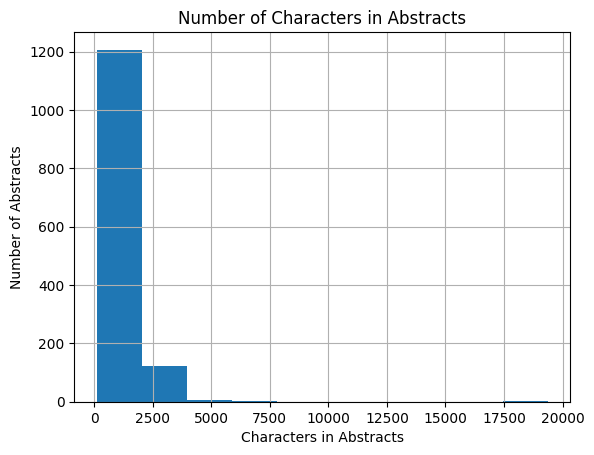

In [7]:
## Number of characters in each abstracts
df['Abstract'].str.len().hist().set_title('Number of Characters in Abstracts')

# Naming y/x-axis
plt.xlabel('Characters in Abstracts')
plt.ylabel('Number of Abstracts')

#Saving plot as png image
plt.savefig('char_in_abstracts_hist.png')

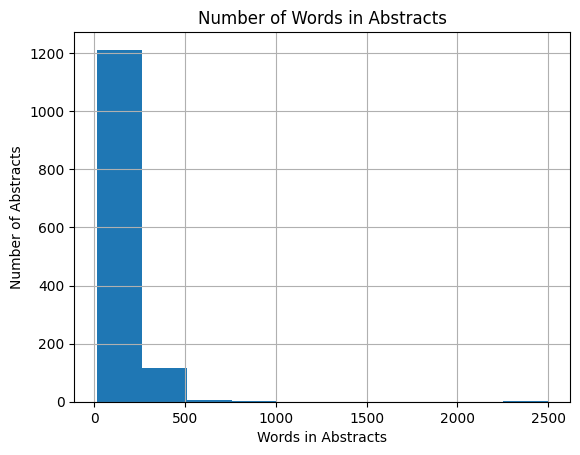

In [8]:
## Number of words in each abstracts
def plot_word_number_histogram(text,plot_title):
    text.str.split().\
        map(lambda x: len(x)).\
        hist().set_title(plot_title)

plot_title = 'Number of Words in Abstracts'
plot_word_number_histogram(df['Abstract'],plot_title)

# Naming y/x-axis
plt.xlabel('Words in Abstracts')
plt.ylabel('Number of Abstracts')

#Saving plot as png image
plt.savefig('words_in_abstracts_hist.png')

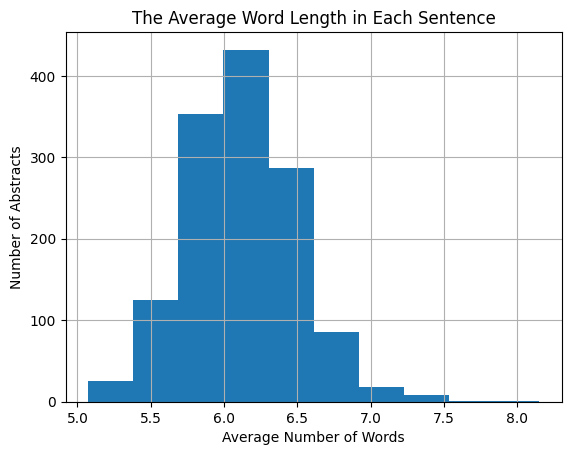

In [9]:
# The average word length in each sentence of each abstracts
def plot_word_length_histogram(text,plot_title):
    text.str.split().\
        apply(lambda x : [len(i) for i in x]). \
        map(lambda x: np.mean(x)).\
        hist().set_title(plot_title)

plot_title = 'The Average Word Length in Each Sentence'
plot_word_length_histogram(df['Abstract'],plot_title)

# Naming y/x-axis
plt.xlabel('Average Number of Words')
plt.ylabel('Number of Abstracts')

#Saving plot as png image
plt.savefig('avg_words_in_abstracts_hist.png')

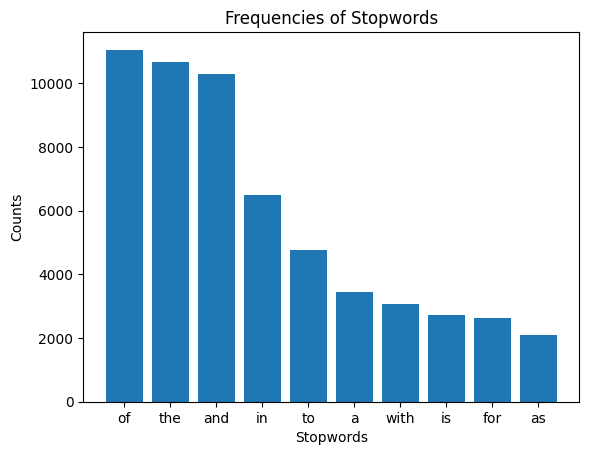

In [10]:
# Plot to see which stopwords dominate each abstract
def plot_top_stopwords_barchart(text):
    new = text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)
    plt.title('Frequencies of Stopwords')
    plt.xlabel('Stopwords')
    plt.ylabel('Counts')

plot_top_stopwords_barchart(df['Abstract'])

#Saving plot as png image
plt.savefig('stopwords_freq.png')

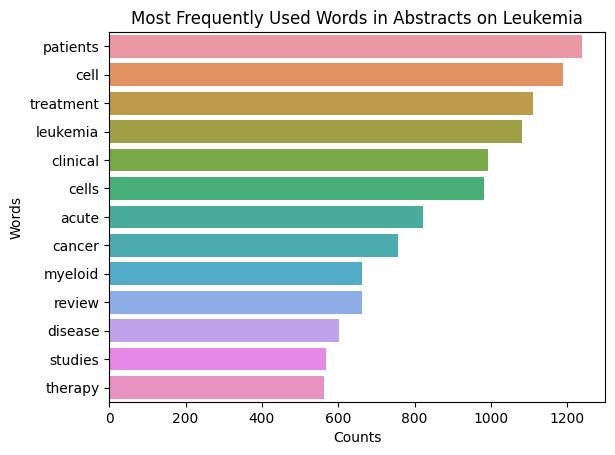

In [11]:
# See which words occur frequently in the abstracts besides stop words
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    lower_df = text.apply(lambda x: x.lower())
    new = lower_df.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1

    counter=Counter(corpus)
    most=counter.most_common()
    x = []
    y = []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)
    plt.title('Most Frequently Used Words in Abstracts on Leukemia')
    plt.xlabel('Counts')
    plt.ylabel('Words')

plot_top_non_stopwords_barchart(df['Abstract'])

#Saving plot as png image
plt.savefig('words_freq.png')

### Ngram Exploration

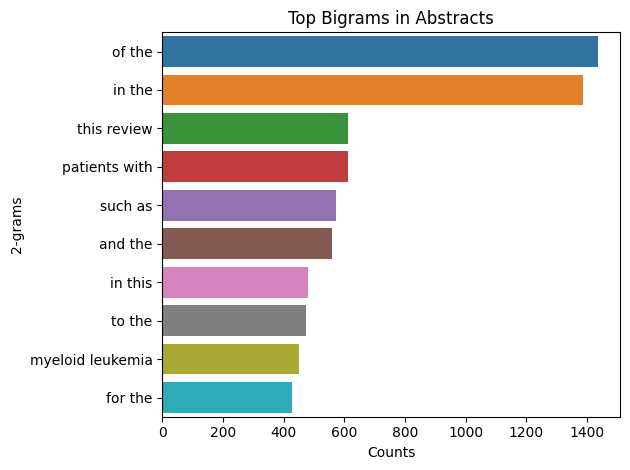

In [12]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    plt.xlabel('Counts')

# bigram
plot_top_ngrams_barchart(df['Abstract'],2)
plt.title('Top Bigrams in Abstracts')
plt.ylabel('2-grams')

#Saving plot as png image
plt.tight_layout()
plt.savefig('2gram.png')

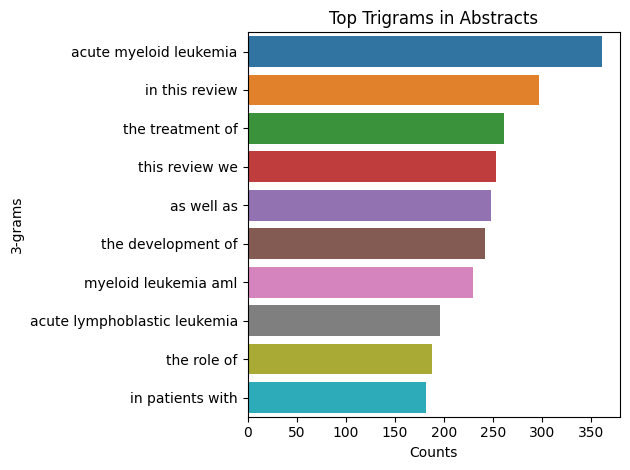

In [13]:
# trigram
plot_top_ngrams_barchart(df['Abstract'],3)
plt.title('Top Trigrams in Abstracts')
plt.ylabel('3-grams')

#Saving plot as png image
plt.tight_layout()
plt.savefig('3gram.png')

### Topic modeling with pyLDAvis

In [14]:
# create a bag of words and initiate the LDA model
def get_lda_objects(text):
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')    
    stop=set(stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [15]:
#generate bag of words
lda_model, bow_corpus, dic = get_lda_objects(df['Abstract'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [16]:
# show LDA topics
lda_model.show_topics()

[(0,
  '0.013*"AML" + 0.009*"cell" + 0.009*"leukemia" + 0.009*"treatment" + 0.007*"disease" + 0.006*"MDS" + 0.006*"myeloid" + 0.005*"clinical" + 0.005*"therapy" + 0.005*"The"'),
 (1,
  '0.019*"patient" + 0.011*"treatment" + 0.010*"cell" + 0.009*"leukemia" + 0.009*"therapy" + 0.008*"disease" + 0.008*"The" + 0.008*"AML" + 0.007*"clinical" + 0.005*"review"'),
 (2,
  '0.018*"cancer" + 0.016*"cell" + 0.008*"leukemia" + 0.008*"The" + 0.008*"treatment" + 0.008*"therapy" + 0.007*"patient" + 0.006*"study" + 0.006*"review" + 0.005*"tumor"'),
 (3,
  '0.026*"cell" + 0.007*"The" + 0.007*"leukemia" + 0.006*"protein" + 0.006*"review" + 0.005*"disease" + 0.005*"HTLV-1" + 0.005*"T-cell" + 0.004*"role" + 0.004*"pathway"')]

In [17]:
#  visualizes the results of LDA interactively
plot_lda_vis(lda_model, bow_corpus, dic)


/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.066597 -0.020773       1        1  37.256951
2     -0.011577 -0.059332       2        1  29.151635
3     -0.100733  0.020248       3        1  18.900177
0      0.045713  0.059857       4        1  14.691237, topic_info=            Term         Freq        Total Category  logprob  loglift
191          AML   882.000000   882.000000  Default  30.0000  30.0000
103         cell  2433.000000  2433.000000  Default  29.0000  29.0000
99        cancer  1232.000000  1232.000000  Default  28.0000  28.0000
196          MDS   170.000000   170.000000  Default  27.0000  27.0000
652       HTLV-1   157.000000   157.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
558        agent    60.947133   304.299480   Topic4  -5.9889   0.3099
143   malignancy    70.813760   580.240456   Topic4  -5.8388  -0.1855
219  development    69.898898   581.731055   Topic4  -5.8518  -0.2010
208   associated    64.328487   399.108944   Topic4  -5.9349   0.0927
11          This    64.742505   501.070861   Topic4  -5.9285  -0.1284

[360 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
15006      4  0.854911         -819T
9206       4  0.854924          6-MP
13787      4  0.854862  6-MP-induced
2973       1  0.925367         :ABL1
2973       2  0.042062         :ABL1
...      ...       ...           ...
186        3  0.777468         virus
186        4  0.012642         virus
2405       2  0.954579         waste
4441       2  0.904396  zanubrutinib
4441       3  0.069569  zanubrutinib

[688 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

In [18]:
#Saving plot as interactive html
x = plot_lda_vis(lda_model, bow_corpus, dic)
pyLDAvis.save_html(x, 'lda_plot.html')

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [19]:
### Word cloud

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk

def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    
    plt.imshow(wordcloud)

    #Saving plot as png image
    plt.savefig('leukemia_wc.png',bbox_inches='tight')
    plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


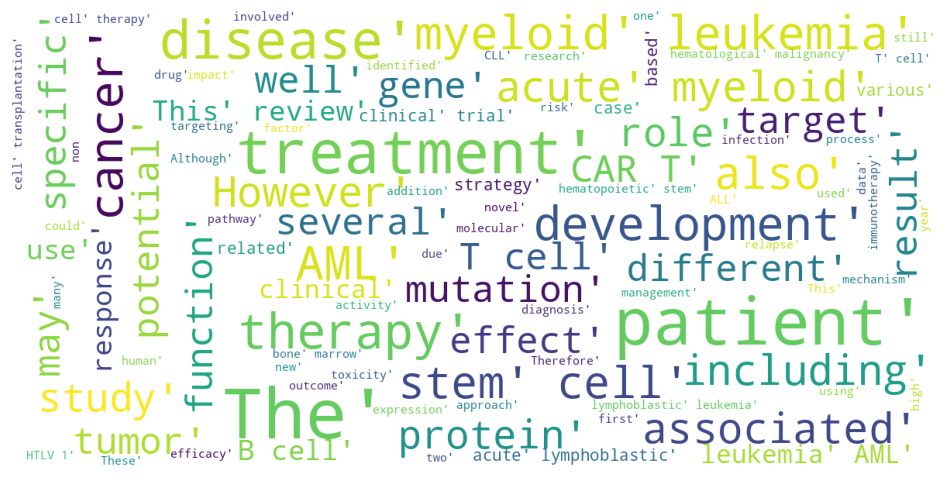

In [21]:
plot_wordcloud(df['Abstract'])

### Sentiment analysis

#### Textblob

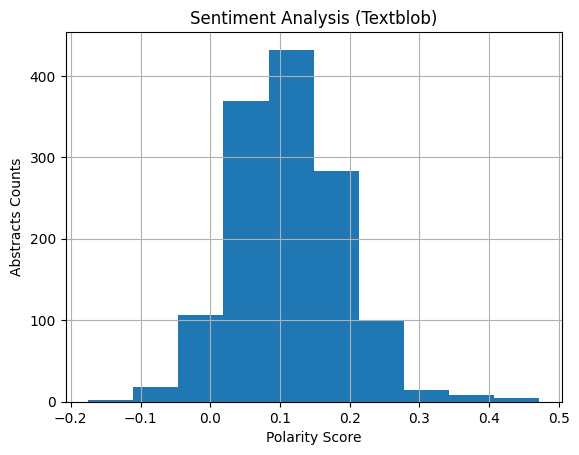

In [22]:
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
    
def plot_polarity_histogram(text,plot_title):
    
    def _polarity(text):
        return TextBlob(text).sentiment.polarity
        
    polarity_score =text.apply(lambda x : _polarity(x))
    polarity_score.hist().set_title(plot_title)

# evaluate sentiment score of the abstracts
plot_title = 'Sentiment Analysis (Textblob)'
plot_polarity_histogram(df['Abstract'],plot_title)
plt.xlabel('Polarity Score')
plt.ylabel('Abstracts Counts')

# Save image as a png
plt.savefig('sentiment_textblob.png')

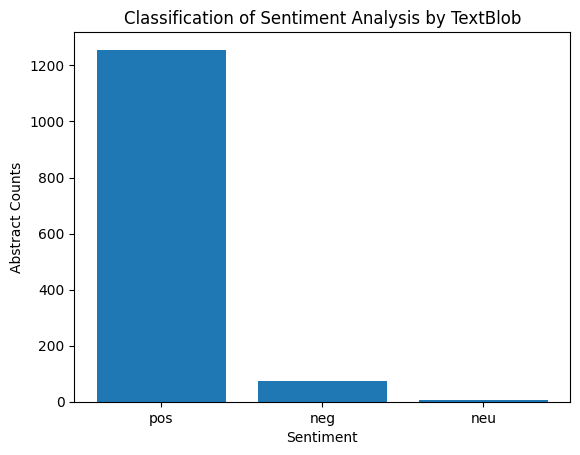

In [23]:
# Classifying the abstracts as negative, positive, or neutral based on polarity score
text = df['Abstract'].copy()
def polarity(text):
    return TextBlob(text).sentiment.polarity
polarity_score =text.apply(lambda x : polarity(x))

df['polarity_score']=text.apply(lambda x : polarity(x))

def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'

df['polarity']=df['polarity_score'].map(lambda x: sentiment(x))

#bar chart showing the polarity score of the abstracts
plt.bar(df.polarity.value_counts().index,
        df.polarity.value_counts())
plt.title('Classification of Sentiment Analysis by TextBlob')
plt.xlabel('Sentiment')
plt.ylabel('Abstract Counts')

# Save image as a png
plt.savefig('sentiment_class_textblob.png')

In [24]:
# Look at some of the positive headlines
df[df['polarity']=='pos']['Abstract'].head()

0    PURPOSE: This work reports a rare case of spon...
1    HBV is one of the most widespread hepatitis vi...
2    Myelodysplastic syndromes (MDS) are clonal hem...
3    Pre-B-cell leukemia homeobox transcription fac...
4    Minimal/measurable residual disease (MRD) moni...
Name: Abstract, dtype: object

In [25]:
# Look at some of the negative headlines
df[df['polarity']=='neg']['Abstract'].head()

9     Slowly progressive spastic paraparesis with bl...
26    Despite significant improvements in treatment ...
38    Hairy cell leukemia (HCL) is an incurable, rar...
56    Myeloproliferative neoplasms (MPNs) are cancer...
88    OBJECTIVE: To estimate the dose-response assoc...
Name: Abstract, dtype: object

In [26]:
# Look at some of the neutral headlines
df[df['polarity']=='neu']['Abstract'].head()

254    miR-20b is a microRNA with diverse and somehow...
470    Waldenström macroglobulinemia is an indolent, ...
839    RNA binding proteins that act at the post-tran...
859    High-throughput sequencing and functional char...
962    Gene sequencing of blood plasma simultaneously...
Name: Abstract, dtype: object

#### Vader sentiment analysis

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


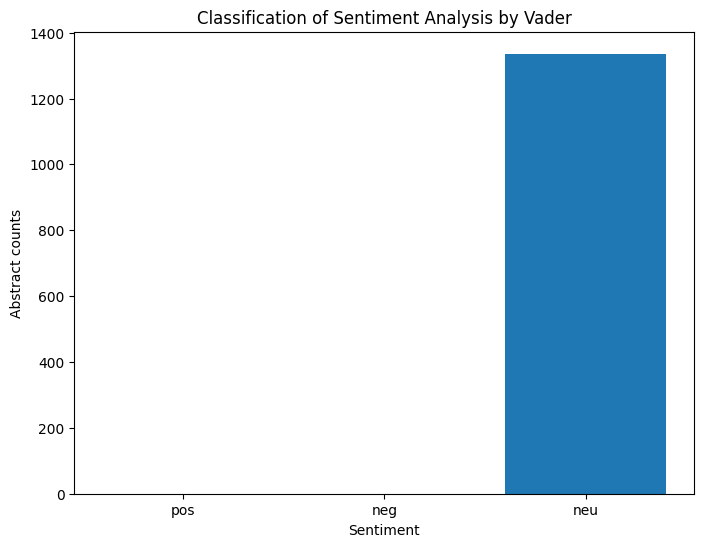

In [27]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    ss.pop('compound')
    #return ss
    return np.argmax(list(ss.values())[:-1])

df['polarity']=df['Abstract'].map(lambda x: get_vader_score(x))

# Define the order of sentiment categories for the x-axis
sentiment_order = ['pos','neg','neu']
polarity_counts = df['polarity'].value_counts().rename({1: 'neu'})
polarity_counts = polarity_counts.reindex(sentiment_order, fill_value=0)

# generate sentiment bar charts
plt.figure(figsize=(8,6))
plt.bar(polarity_counts.index, polarity_counts)
plt.title('Classification of Sentiment Analysis by Vader')
plt.xlabel('Sentiment')
plt.ylabel('Abstract counts')

# Save image as a png
plt.savefig('sentiment_class_vader.png')
## Seems like the sentiment of the abstracts is neutral!! As expected from research abstracts...

### Named entity recognition

In [28]:
def plot_named_entity_barchart(text):
    nlp = spacy.load("en_core_web_sm")
    
    def _get_ner(text):
        doc=nlp(text)
        return [X.label_ for X in doc.ents]
    
    ent=text.apply(lambda x : _get_ner(x))
    ent=[x for sub in ent for x in sub]
    counter=Counter(ent)
    count=counter.most_common()
    
    x,y=map(list,zip(*count))
    sns.barplot(x=y,y=x)
    plt.title('Named Entity Recognition Frequencies')
    plt.xlabel('Counts')
    plt.ylabel('Entity Types')


Please wait, the plot will take roughly 1-2 minute to generate.....



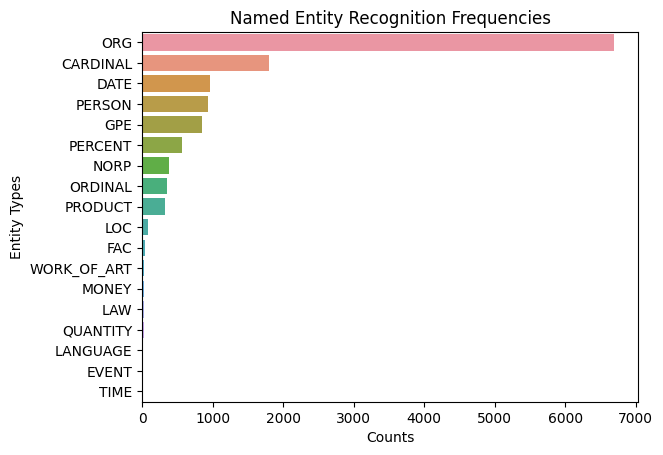

In [29]:
# visualize entity frequencies
print("\nPlease wait, the plot will take roughly 1-2 minute to generate.....\n")
plot_named_entity_barchart(df['Abstract'])

# Save image as a png
plt.savefig('entity_recog.png')


Please wait, the plot will take roughly 1-2 minute to generate.....



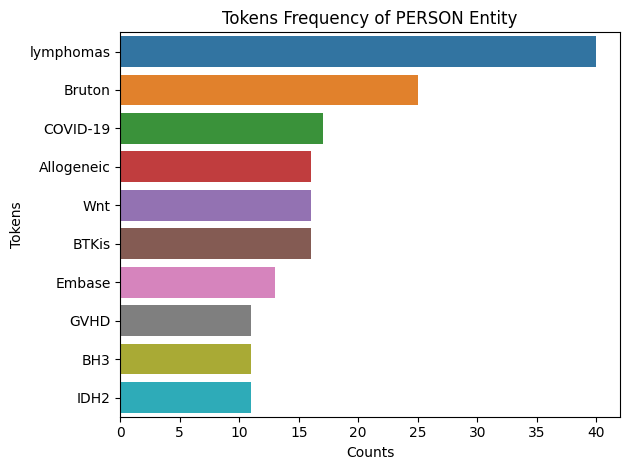

In [30]:
def plot_most_common_named_entity_barchart(text, entity="PERSON"):
    nlp = spacy.load("en_core_web_sm")
    
    def _get_ner(text,ent):
        doc=nlp(text)
        return [X.text for X in doc.ents if X.label_ == ent]

    entity_filtered=text.apply(lambda x: _get_ner(x,entity))
    entity_filtered=[i for x in entity_filtered for i in x]
    
    counter=Counter(entity_filtered)
    x,y=map(list,zip(*counter.most_common(10)))
    sns.barplot(x=y,y=x).set_title(entity)
    plt.xlabel('Counts')
    plt.ylabel('Tokens')


#visualize the most common token by the PERSON entity
print("\nPlease wait, the plot will take roughly 1-2 minute to generate.....\n")
plot_most_common_named_entity_barchart(df['Abstract'], entity="PERSON")
plt.title('Tokens Frequency of PERSON Entity')

#Saving plot as png image
plt.tight_layout()
plt.savefig('PERSON.png')


Please wait, the plot will take roughly 1-2 minute to generate.....



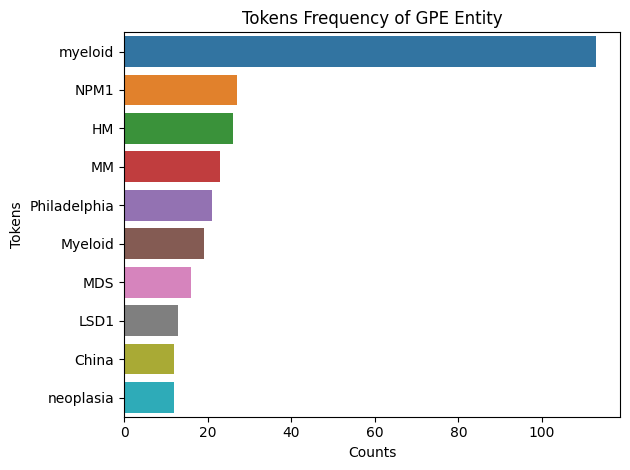

In [31]:
#visualize the most common token by the GPE entity
print("\nPlease wait, the plot will take roughly 1-2 minute to generate.....\n")
plot_most_common_named_entity_barchart(df['Abstract'], entity="GPE")
plt.title('Tokens Frequency of GPE Entity')

#Saving plot as png image
plt.tight_layout()
plt.savefig('GPE.png')


Please wait, the plot will take roughly 1-2 minute to generate.....



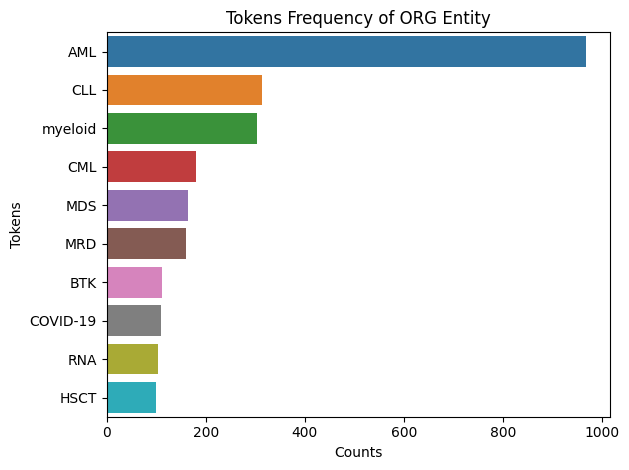

In [32]:
#visualize the most common token by the ORG entity
print("\nPlease wait, the plot will take roughly 1-2 minute to generate.....\n")
plot_most_common_named_entity_barchart(df['Abstract'], entity="ORG")
plt.title('Tokens Frequency of ORG Entity')

#Saving plot as png image
plt.tight_layout()
plt.savefig('ORG.png')


Please wait, the plot will take roughly 1-2 minute to generate.....



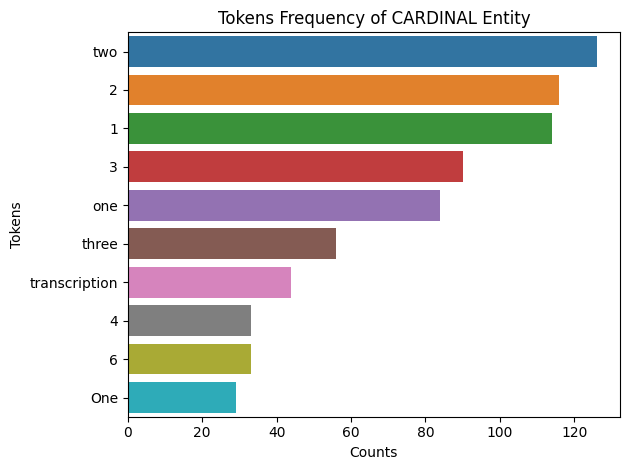

In [33]:
#visualize the most common token by the Cardinal entity
print("\nPlease wait, the plot will take roughly 1-2 minute to generate.....\n")
plot_most_common_named_entity_barchart(df['Abstract'], entity="CARDINAL")

plt.title('Tokens Frequency of CARDINAL Entity')

#Saving plot as png image
plt.tight_layout()
plt.savefig('CARDINAL.png')

### Speech tagging

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


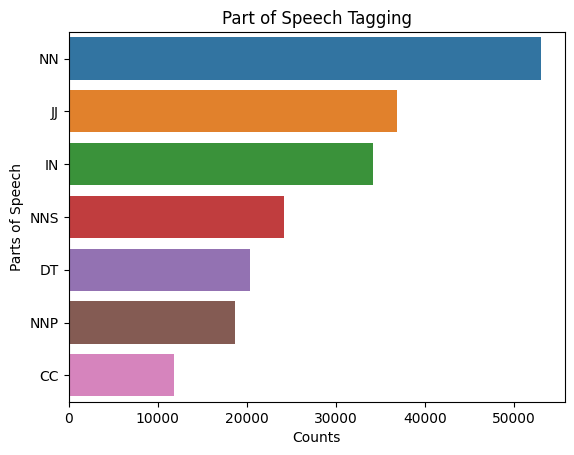

In [34]:
def plot_parts_of_speach_barchart(text):
    nltk.download('averaged_perceptron_tagger')

    def _get_pos(text):
        pos=nltk.pos_tag(word_tokenize(text))
        pos=list(map(list,zip(*pos)))[1]
        return pos
    
    tags=text.apply(lambda x : _get_pos(x))
    tags=[x for l in tags for x in l]
    cleaned_tags = [x for x in tags if x.isalpha()]
    counter=Counter(cleaned_tags)
    x,y=list(map(list,zip(*counter.most_common(7))))
    
    sns.barplot(x=y,y=x)
    plt.xlabel('Counts')
    plt.ylabel('Parts of Speech')


# Visualize the type of words that dominate the abstracts. As expected: NN (Nouns)
plot_parts_of_speach_barchart(df['Abstract'])
plt.title('Part of Speech Tagging')

#Saving plot as png image
plt.savefig('pos_tagging.png')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


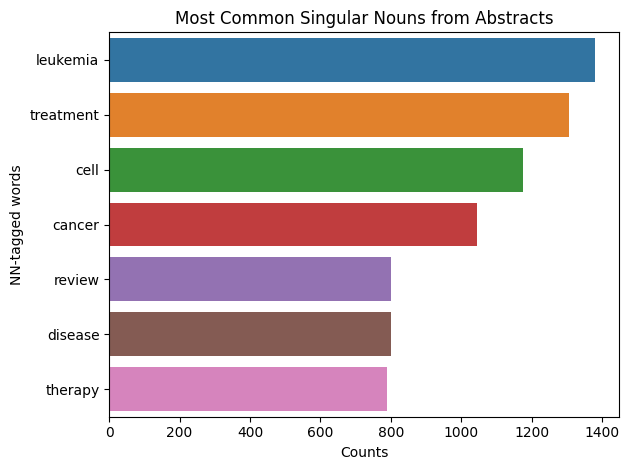

In [35]:
def plot_most_common_part_of_speach_barchart(text, part_of_speach='NN'):
    nltk.download('averaged_perceptron_tagger')
    
    def _filter_pos(text):
        pos_type=[]
        pos=nltk.pos_tag(word_tokenize(text))
        for word,tag in pos:
            if tag==part_of_speach:
                pos_type.append(word)
        return pos_type


    words=text.apply(lambda x : _filter_pos(x))
    words=[x for l in words for x in l]
    counter=Counter(words)
    x,y=list(map(list,zip(*counter.most_common(7))))
    sns.barplot(x=y,y=x)
    plt.xlabel('Counts')
    plt.ylabel('NN-tagged words')

# Plot the common NN (Nouns) that dominate the abstracts. As expected "Leukemia"
plot_most_common_part_of_speach_barchart(df['Abstract'])
plt.title('Most Common Singular Nouns from Abstracts')

#Saving plot as png image
plt.tight_layout()
plt.savefig('nn_tagging.png')

### Text Complexity

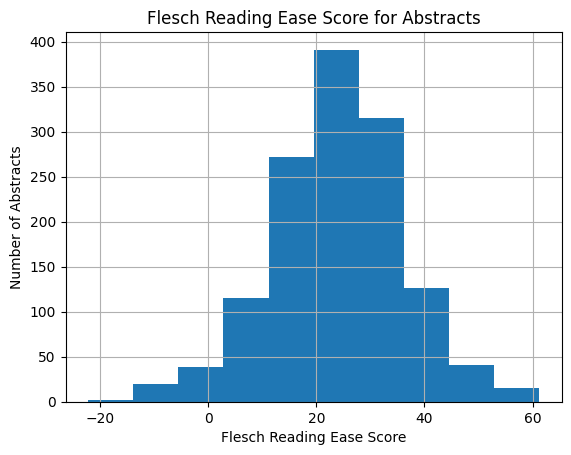

In [36]:
from textstat import flesch_reading_ease

def plot_text_complexity_histogram(text,plot_title):
    text.\
        apply(lambda x : flesch_reading_ease(x)).\
        hist().set_title(plot_title)

plot_title = 'Flesch Reading Ease Score for Abstracts'

# Naming y/x-axis
plt.xlabel('Flesch Reading Ease Score')
plt.ylabel('Number of Abstracts')


# visualize the flesch reading ease score
plot_text_complexity_histogram(df['Abstract'],plot_title)

#Saving plot as png image
plt.savefig('reading_hist.png')

In [37]:
# Check abstracts that have a readability score below 5
reading = [flesch_reading_ease(headline) for headline in df['Abstract']]
x=[i for i in range(len(reading)) if reading[i]<5]
df.iloc[x]['Abstract'].head(10)

2      Myelodysplastic syndromes (MDS) are clonal hem...
16     Ageing is a complex process characterized main...
70     Treatment for acute myeloid leukemia (AML) has...
95     A comprehensive understanding of the mechanism...
137    Many patients with hematological malignancies,...
140    The human genome is pervasively transcribed, p...
189    Hematopoietic stem cell transplantation (HSCT)...
197    The microbiota is directly involved in the hos...
255    l-asparaginase is a first-line medicine used f...
256    The recently published International Consensus...
Name: Abstract, dtype: object